In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
import itertools

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold


sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings

from loaders import load_peanut
from decoders import lr_decoder

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [73]:
# Can one decode position from OFC?
fl = '/mnt/Secondary/data/peanut/data_dict_peanut_day14.obj'
dat = load_peanut(fl, epoch=6, region='OFC', boxcox=0.5, bin_width=50, spike_threshold=200, speed_threshold=4)

In [74]:
train_test_split = list(KFold(n_splits=5, shuffle=False).split(dat['spike_rates'].squeeze()))

In [75]:
fold = 4
Xtrain = dat['spike_rates'].squeeze()[train_test_split[fold][0], :]
Xtest = dat['spike_rates'].squeeze()[train_test_split[fold][1], :]
Ztrain = dat['behavior'].squeeze()[train_test_split[fold][0], :]
Ztest = dat['behavior'].squeeze()[train_test_split[fold][1], :]

In [76]:
dw = np.array([2, 4, 6])
lag = np.array([0, 1, 2, 3, 4, 5])

r2_array = np.zeros((len(dw), len(lag)))

for i, d in enumerate(dw):
    for j, l in enumerate(lag):
        r2, _ = lr_decoder(Xtest, Xtrain, Ztest, Ztrain, trainlag=l, testlag=l, decoding_window=d, include_velocity=False, include_acc=False)
        r2_array[i, j] = r2

In [77]:
r2_array

array([[0.07230029, 0.0729535 , 0.07329694, 0.07318841, 0.0734397 ,
        0.07364987],
       [0.09520721, 0.09594952, 0.09606901, 0.09613642, 0.09575174,
        0.09631858],
       [0.0926808 , 0.09374635, 0.0936636 , 0.09427479, 0.09551097,
        0.09686476]])

In [98]:
with open('/mnt/Secondary/data/postprocessed/peanut_decoding_df.dat', 'rb') as f:
    peanut_decoding_df = pickle.load(f)

peanut_decoding_df = pd.DataFrame(peanut_decoding_df)
pdf_fca = apply_df_filters(peanut_decoding_df, dimreduc_method='LQGCA', dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':5})

#fig, ax = plt.subplots(4, 2, figsize=(10, 12))
epochs = np.unique(peanut_decoding_df['epoch'].values)
folds = np.unique(peanut_decoding_df['fold_idx'].values)
dimvals = np.unique(peanut_decoding_df['dim'].values)
decoder_args = [{'trainlag': 0, 'testlag': 0, 'decoding_window': 6}, {'trainlag': 3, 'testlag': 3, 'decoding_window': 6}, {'trainlag': 6, 'testlag': 6, 'decoding_window': 6}]

r2 = np.zeros((epochs.size, len(decoder_args), folds.size, dimvals.size))

for i, epoch in enumerate(epochs):
    for k, da in enumerate(decoder_args):
        for f, fold in enumerate(folds):
            for d, dimval in enumerate(dimvals):            
                df_ = apply_df_filters(pdf_fca, epoch=epoch, fold_idx=fold, dim=dimval, decoder_args=da)
                try:
                    assert(df_.shape[0] == 1)
                except:
                    pdb.set_trace()
                r2[i, k, f, d] = df_.iloc[0]['r2'][0]


# Something went wrong with PCA results, just run them here real quick:
pca_r2 = np.zeros((epochs.size, len(decoder_args), 5, dimvals.size))
for i, epoch in tqdm(enumerate(epochs)):
    dat = load_peanut('/mnt/Secondary/data/peanut/data_dict_peanut_day14.obj', epoch=epoch, spike_threshold=200)
    X = dat['spike_rates']
    Y = dat['behavior']
    train_test = list(KFold(n_splits=5).split(X))
    for k, da in enumerate([decoder_args[0]]):
        for f, fold in enumerate(folds):
            for d, dimval in enumerate(dimvals):            

                df_ = apply_df_filters(peanut_decoding_df, epoch=epoch, dimreduc_method='PCA', fold_idx=fold, dim=dimval, decoder_args=da)
                try:
                    coef = df_.iloc[0]['coef'][:, 0:dimval]         
                except:
                    pdb.set_trace()

                train_idxs = train_test[f][0]
                test_idxs = train_test[f][1]

                Ytrain = Y[train_idxs]
                Ytest = Y[test_idxs]

                Xtrain = X[train_idxs] @ coef
                Xtest = X[test_idxs] @ coef


                try:
                    r2_pos, r2_vel, r2_acc, decoder_obj = lr_decoder(Xtest, Xtrain, Ytest, Ytrain, **da)
                except:
                    pdb.set_trace()
                pca_r2[i, k, f, d] = r2_pos

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
8it [00:51,  6.44s/it]


In [81]:
# Assemble OFC results
with open('/mnt/Secondary/data/postprocessed/OFC_decoding_df.dat', 'rb') as f:
    ofc_decoding_df = pickle.load(f)
ofc_decoding_df = pd.DataFrame(ofc_decoding_df)

In [84]:
ofc_decoding_df.iloc[0]['loader_args']

{'bin_width': 50,
 'epoch': 2,
 'filter_fn': 'none',
 'filter_kwargs': {},
 'boxcox': 0.5,
 'spike_threshold': 200,
 'speed_threshold': 4,
 'region': 'OFC'}

In [110]:
odf_fca = apply_df_filters(ofc_decoding_df, dimreduc_method='LQGCA', dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})
odf_pca = apply_df_filters(ofc_decoding_df, dimreduc_method='PCA')

#fig, ax = plt.subplots(4, 2, figsize=(10, 12))
loader_args = [{'bin_width': 50,
                'epoch': e,
                'filter_fn': 'none',
                'filter_kwargs': {},
                'boxcox': 0.5,
                'spike_threshold': 200,
                'speed_threshold': 4,
                'region': 'OFC'} for e in np.arange(2, 18, 2)]
# Do not include fold 1
folds = np.unique(ofc_decoding_df['fold_idx'].values)
dimvals = np.unique(ofc_decoding_df['dim'].values)

r2o = np.zeros((len(loader_args), folds.size, dimvals.size, 2))

for i, la in enumerate(loader_args):
    for f, fold in enumerate(folds):
        for d, dimval in enumerate(dimvals):            

            df_ = apply_df_filters(odf_fca, loader_args=la, fold_idx=fold, dim=dimval)
            assert(df_.shape[0] == 1)

            r2o[i, f, d, 0] = df_.iloc[0]['r2'][0]

            df_ = apply_df_filters(odf_pca, loader_args=la, fold_idx=fold, dim=dimval)
            assert(df_.shape[0] == 1)

            r2o[i, f, d, 1] = df_.iloc[0]['r2'][0]


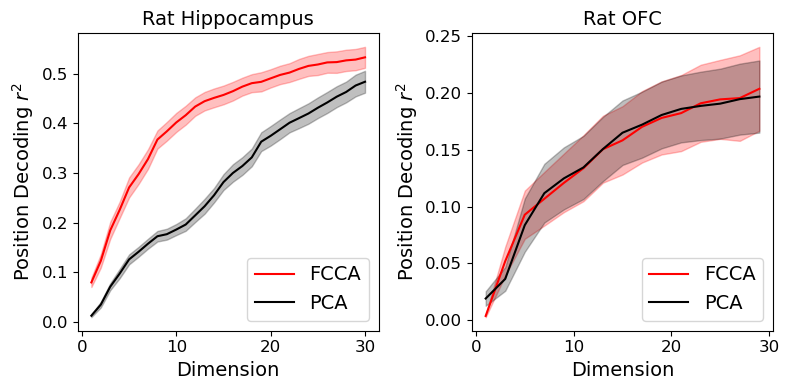

In [111]:
#fig, ax = plt.subplots(4, 2, figsize=(8, 16))
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

fca_mean = np.mean(np.mean(r2[:, 0, :, :], axis=1), axis=0)

# Move the fold indices up and then reshape to calc std
fca_std = np.std(r2[:, 0, :, :].reshape((-1, 30)), axis=0)/np.sqrt(40)

pca_mean = np.mean(np.mean(pca_r2[:, 0, :, :], axis=1), axis=0)
pca_std = np.std(pca_r2[:, 0, :, :].reshape((-1, 30)), axis=0)/np.sqrt(40)

ax[0].fill_between(np.arange(1, 31), fca_mean - fca_std, fca_mean + fca_std, color='r', alpha=0.25)
ax[0].fill_between(np.arange(1, 31), pca_mean - pca_std, pca_mean + pca_std, color='k', alpha=0.25)

ax[0].plot(np.arange(1, 31), fca_mean, color='r')
ax[0].plot(np.arange(1, 31), pca_mean, color='k')

ax[0].legend(['FCCA', 'PCA'], loc='lower right', fontsize=14)
ax[0].set_title('Rat Hippocampus', fontsize=14)
ax[0].set_xlabel('Dimension', fontsize=14)
ax[0].set_ylabel('Position Decoding ' + r'$r^2$', fontsize=14)    
ax[0].tick_params(axis='both', labelsize=12)

fca_mean = np.mean(np.mean(r2o[:, :, :, 0], axis=1), axis=0)

# Move the fold indices up and then reshape to calc std
fca_std = np.std(r2o[:, :, :, 0].reshape((-1, dimvals.size)), axis=0)/np.sqrt(8*4)

pca_mean = np.mean(np.mean(r2o[:, :, :, 1], axis=1), axis=0)
pca_std = np.std(r2o[:, :, :, 1].reshape((-1, dimvals.size)), axis=0)/np.sqrt(8*4)

ax[1].fill_between(dimvals, fca_mean - fca_std, fca_mean + fca_std, color='r', alpha=0.25)
ax[1].fill_between(dimvals, pca_mean - pca_std, pca_mean + pca_std, color='k', alpha=0.25)

ax[1].plot(dimvals, fca_mean, color='r')
ax[1].plot(dimvals, pca_mean, color='k')

ax[1].legend(['FCCA', 'PCA'], loc='lower right', fontsize=14)
ax[1].set_title('Rat OFC', fontsize=14)
ax[1].set_xlabel('Dimension', fontsize=14)
ax[1].set_ylabel('Position Decoding ' + r'$r^2$', fontsize=14)    
ax[1].tick_params(axis='both', labelsize=12)


fig.tight_layout()
#    fig.savefig('%s/peanut_decoding.pdf' % figpath, bbox_inches='tight', pad_inches=0)
    # fig.savefig('peanut_decoding.pdf', bbox_inches='tight', pad_inches=0)


In [112]:
# What are the subspace angles?
ssa = np.zeros((len(loader_args), len(folds)))
for i, la in enumerate(loader_args):
    for f, fold in enumerate(folds):

        df_ = apply_df_filters(odf_fca, loader_args=la, fold_idx=fold, dim=dimval)
        assert(df_.shape[0] == 1)
        Vf = df_.iloc[0]['coef']

        df_ = apply_df_filters(odf_pca, loader_args=la, fold_idx=fold, dim=dimval)
        assert(df_.shape[0] == 1)
        Vp = df_.iloc[0]['coef']

        ssa[i, f] = np.mean(scipy.linalg.subspace_angles(Vf, Vp))


In [113]:
ssa

array([[1.29111852, 1.29359329, 1.30350814, 1.29485926, 1.29853801],
       [1.32725332, 1.30120302, 1.30964855, 1.315273  , 1.30770277],
       [1.31496694, 1.30043969, 1.29325703, 1.29111044, 1.29477608],
       [1.26525652, 1.25891207, 1.26088622, 1.25798736, 1.26158246],
       [1.29277203, 1.29544141, 1.29420854, 1.29170927, 1.27993103],
       [1.26995464, 1.2632716 , 1.28218553, 1.26978887, 1.29071069],
       [1.2829846 , 1.27498542, 1.2753448 , 1.27129054, 1.28145952],
       [1.30541484, 1.3067642 , 1.29310454, 1.28914591, 1.29085021]])

In [ ]:
# Despite the lack of difference in decoding performance, the subspace angles are significant... How do we think about this case?